# Training the segmented data

To reproduce the results from _, this notebook trains different models for the surface type classification. The cross-validation (cv=10) accuracy falls in a range of 78% - 81%. Therefore it is concluded that any of those model can provide sufficent image classification. The models that where evaluated are the following: 

- Random Forest 
- Multi Layer Percepton
- Histogram Gradient Boosting
- K-Neighbors 
- Support Vector

The analysis was run on a 13th Gen Intel® Core™ i7-1360P Chip on a machine with 32GB RAM. 

In [91]:
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score, cross_val_predict, train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
#from helper import plot_confusion_matrix, print_classification_report

In [92]:
from autogluon.tabular import TabularDataset, TabularPredictor

In [93]:
df = pd.read_csv('../../data/training_segment.csv')[2:]

label_cols = [col for col in df.columns if 'label.' in col]
max_cols = [col for col in df.columns if 'max' in col]
min_cols = [col for col in df.columns if 'min' in col]
var_cols = [col for col in df.columns if 'var.' in col]  
cols_to_drop = label_cols + ['variable'] + max_cols + min_cols + var_cols

df = df.drop(columns=cols_to_drop).where((df['label'] != 0) & (df['label'] != 3)).dropna()

no_cold_thin_ice = (df['label'] == 2) & (df['mean'] < -20)

df = df.where(~no_cold_thin_ice).dropna()

train, test = train_test_split(df, test_size=0.2, random_state=42)

print(train.shape, test.shape)

(121976, 6) (30494, 6)


/tmp/ipykernel_2942988/1237463309.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../../data/training_segment.csv')[2:]


In [94]:
train_data = TabularDataset(train)
train_data.describe()

,mean,mean.1,mean.2,mean.3,var,label
count,121976.000000,121976.000000,121976.000000,121976.000000,121976.000000,121976.000000
mean,-19.932873,-20.937013,-21.391240,-19.753211,0.248242,3.319997
std,5.671651,6.334861,6.597037,5.920876,0.759601,1.038358
min,-33.124092,-36.839996,-37.220000,-34.649994,-0.000061,1.000000
25%,-23.996468,-25.359780,-26.068077,-23.694732,0.015039,2.000000
50%,-20.559154,-21.828882,-22.223284,-20.664313,0.028497,4.000000
75%,-16.971069,-17.211628,-17.767481,-16.631756,0.086382,4.000000
max,-1.419830,0.720001,1.730011,2.209992,15.978300,4.000000


In [95]:
predictor = TabularPredictor(label='label').fit(train_data, presets='medium_quality', time_limit=10)


No path specified. Models will be saved in: "AutogluonModels/ag-20240504_101451"
Presets specified: ['medium_quality']
Beginning AutoGluon training ... Time limit = 10s
AutoGluon will save models to "AutogluonModels/ag-20240504_101451"
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.11.9
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Debian 6.1.76-1 (2024-02-01)
CPU Count:          64
Memory Avail:       557.33 GB / 1007.74 GB (55.3%)
Disk Space Avail:   37113.11 GB / 155833.13 GB (23.8%)
Train Data Rows:    121976
Train Data Columns: 5
Label Column:       label
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == float, but few unique label-values observed and label-values can be converted to int).
	3 unique label values:  [4.0, 2.0, 1.0]
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type parameter during pr

In [96]:
predictor.evaluate(test)

{'accuracy': 0.9405784744539909,
 'balanced_accuracy': 0.9110583213238317,
 'mcc': 0.8690563463145733}

In [97]:
predictor.leaderboard(test)

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.940578,0.9452,accuracy,1.707350,0.192424,9.209433,0.002787,0.000739,0.052077,2,True,5
1,KNeighborsUnif,0.938152,0.9420,accuracy,0.561914,0.091850,0.170939,0.561914,0.091850,0.170939,1,True,1
2,KNeighborsDist,0.938152,0.9432,accuracy,1.445767,0.165907,0.174631,1.445767,0.165907,0.174631,1,True,2
3,NeuralNetFastAI,0.924018,0.9272,accuracy,0.258796,0.025777,8.982724,0.258796,0.025777,8.982724,1,True,3
4,LightGBMXT,0.693448,0.6900,accuracy,0.002307,0.001415,0.510681,0.002307,0.001415,0.510681,1,True,4


In [98]:
predictor.feature_importance(test)

Computing feature importance via permutation shuffling for 5 features using 5000 rows with 5 shuffle sets...
	11.4s	= Expected runtime (2.28s per shuffle set)
	16.44s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
mean,0.32876,0.008775,6.085897e-08,5,0.346829,0.310691
mean.3,0.12472,0.004098,1.396423e-07,5,0.133157,0.116283
mean.2,0.10236,0.004926,6.417828e-07,5,0.112503,0.092217
mean.1,0.10228,0.004529,4.601504e-07,5,0.111605,0.092955
var,0.03296,0.002085,1.912042e-06,5,0.037253,0.028667


In [99]:
import xarray as xr
import numpy as np
import pandas as pd

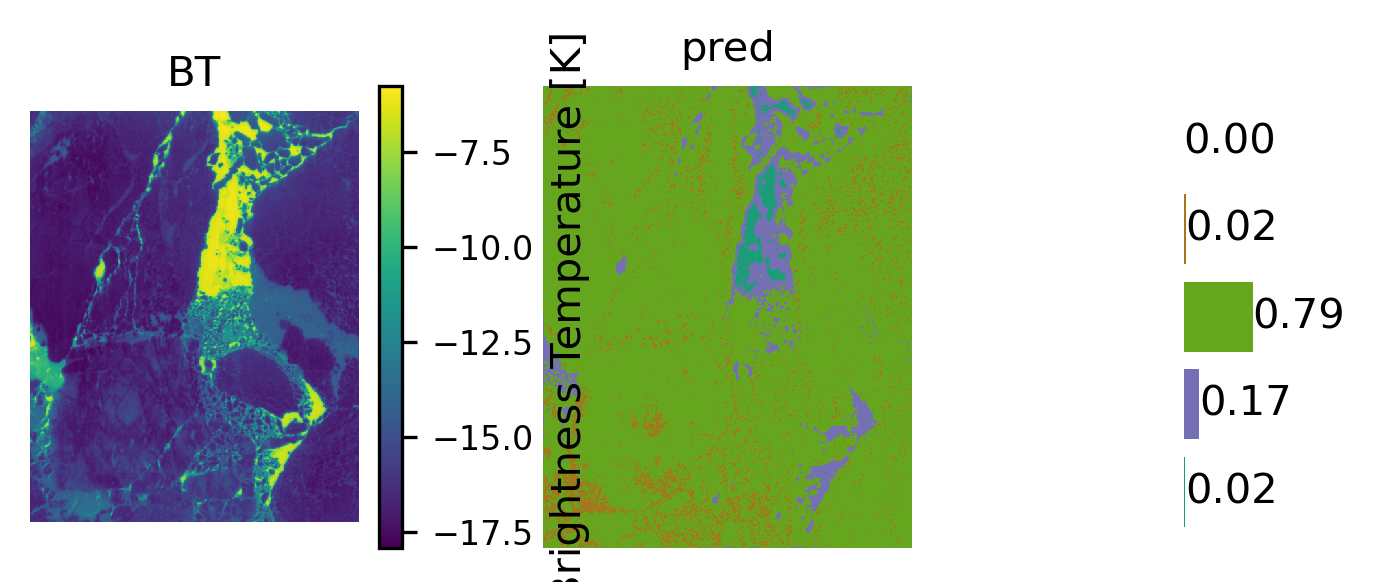

In [101]:
ds = xr.open_dataset('/projekt_agmwend/home_rad/Joshua/HALO-AC3_VELOX_sea_ice/2022-04-04_v_0.1.nc')
test_slice = ds.sel(time='2022-04-04T13:39:02')

X1 = test_slice.BT_2D.isel(band=0).values.flatten()
X1 = test_slice.neighbor_mean.values.flatten()
X2 = test_slice.BT_2D.isel(band=1).values.flatten()
X3 = test_slice.BT_2D.isel(band=3).values.flatten()
X4 = test_slice.BT_2D.isel(band=4).values.flatten()
X5 = test_slice.neighbor_std.values.flatten()

skt = X1 * 1.2 + 4.1

df_X = pd.DataFrame(np.stack([X1, X2, X3, X4, X5], axis=-1), columns=['mean', 'mean.1', 'mean.2', 'mean.3', 'var'])

pred_proba = predictor.predict_proba(df_X).values.reshape(635, 507, 3)

ds_predicted = xr.Dataset(
    {
        'pred_proba': (('x', 'y', 'cl'), pred_proba),
        'label' : (('x', 'y'), np.argmax(pred_proba, axis=-1) * 2 + 1),
        'skin_t' : (('x', 'y'), skt.reshape(635, 507))
    },
    coords={
        'x': test_slice.x,
        'y': test_slice.y,
        'cl': ['1', '3', '5']    
    }
)

water_ice_mix = (ds_predicted['pred_proba'].sel(cl='1') > .25 ) & (ds_predicted['pred_proba'].sel(cl='3') > .25)

### add a second condition for the water_ice_mix: if the skin temperature is below -2.5°C; this is only applied to open water 

cold_water = (ds_predicted['label'] == 1) & (ds_predicted['skin_t'] < -3.5)

water_ice_mix = water_ice_mix | cold_water


ice_snow_mix = (ds_predicted['pred_proba'].sel(cl='3') > .25 ) & (ds_predicted['pred_proba'].sel(cl='5') > .25)
ds_predicted['label'] = ds_predicted['label'].where(~water_ice_mix, 2)
ds_predicted['label'] = ds_predicted['label'].where(~ice_snow_mix, 4)

import matplotlib.pyplot as plt
import json
plt.rcParams.update(json.load(open('/projekt_agmwend/home_rad/Joshua/MasterArbeit/plot_settings.json')))

fig, ax = plt.subplot_mosaic(
    """
    ABC
    """,
    figsize=(6, 2),
    gridspec_kw={'width_ratios': [1, 1, 1], 
                 'hspace': 0.05}

)

im = ds_predicted['label'].plot.contourf(levels=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], cmap='Dark2', ax=ax['B'], add_colorbar=False)
# cbar = ax['B'].collections[0].colorbar
# cbar.set_ticks([1, 2, 3, 4, 5])
# cbar.set_ticklabels(['OW', 'IWM', 'TI', 'ISM', 'SC'])
# cbar.set_label('') 


#cbar_ax = cbar.ax

test_slice.BT_2D.isel(band=0).plot.imshow(ax=ax['A'], cmap='viridis', cbar_kwargs={'label': 'Brightness Temperature [K]'})

### add a bar plot for the predicted classes 

# Plot bar plot for predicted classes
## add divider for the bar plot make_axes_locatable

# from mpl_toolkits.axes_grid1 import make_axes_locatable
# divider = make_axes_locatable(cbar_ax)

# Add axes for the bar plot

# ax_c = divider.append_axes('right', size='100%', pad=0.05)

# ## adjust the x_length of the bar plot 

# ax_c.set_position([0.66, 0.1, 15, 0.5])


colors = im.cmap([0, 1, 2, 3, 4])

tot_count = 507 * 635
#ax_c = plt.axes([0.66, 0.1, 0.2, 0.5])  # Custom position for ax['C']
bars =ax['C'].barh([1, 2, 3, 4, 5], [np.sum(ds_predicted['label'] == i) / tot_count for i in [1, 2, 3, 4, 5]], color=colors, )
ax['C'].bar_label(bars, fmt='%.2f')

ax['A'].set_title('BT')
ax['B'].set_title('pred')


for a in ax.values():
    a.set_aspect('equal')
    a.axis('off')
    a.grid(False)

### smoothen the predictions 

In [35]:
import os
basepath = '/projekt_agmwend/home_rad/Joshua/HALO-AC3_VELOX_sea_ice/'
files = [os.path.join(basepath, f) for f in os.listdir(basepath) if f.endswith('0.1_pred.nc')]
files.sort()
pred_2d_all = xr.concat([xr.open_dataset(file, engine='h5netcdf', chunks={'time' : 250, 'x' : 250, 'y' : 250}) for file in files], dim='time')
files = pd.read_csv('/projekt_agmwend/home_rad/Joshua/MasterArbeit/filenames.csv')['BAHAMAS'].tolist()
ds_bahamas = xr.concat([xr.open_dataset(file) for file in files], dim='tid').rename({'tid' : 'time'})
ds_bahamas = ds_bahamas.assign_coords({'TIME' : ds_bahamas.TIME.values}).rename({'TIME' : 'time'})
ds_bahamas = ds_bahamas.sel(time=pred_2d_all.time, method='nearest') 
pred_2d_all['lat'] = ('time', ds_bahamas.IRS_LAT.values)
pred_2d_all['lon'] = ('time', ds_bahamas.IRS_LON.values)
pred_2d_all[list(ds_bahamas.keys())] = ds_bahamas[list(ds_bahamas.keys())]



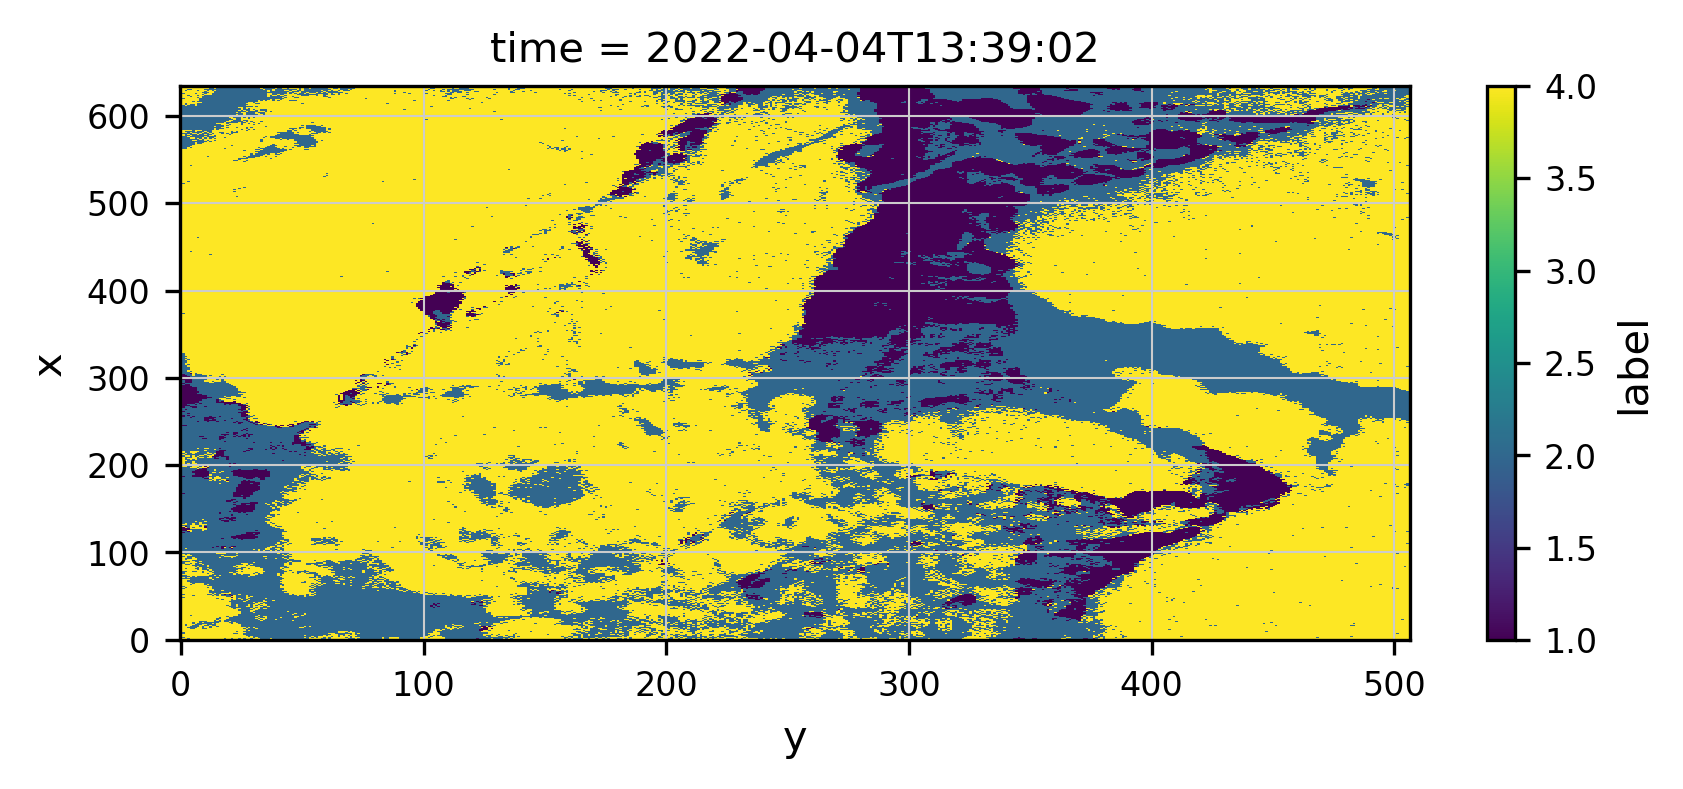

In [37]:
pred_2d_all_sel = pred_2d_all.sel(time='2022-04-04T13:39:02')
pred_2d_all_sel.label.plot.imshow()

NameError: name 'ds_predicted' is not defined

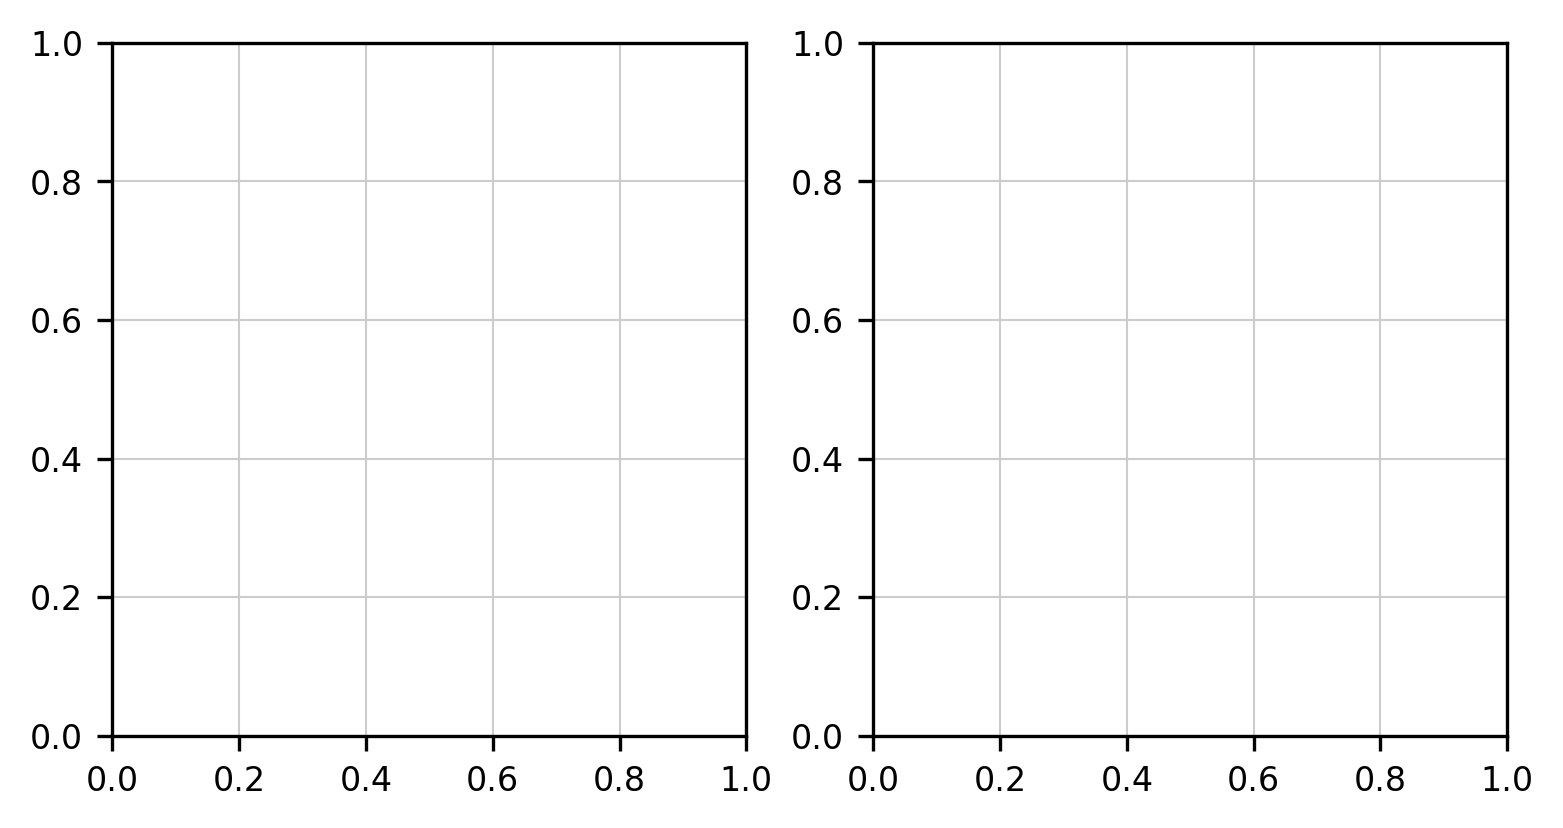

In [1]:
import matplotlib.pyplot as plt
import json
plt.rcParams.update(json.load(open('/projekt_agmwend/home_rad/Joshua/MasterArbeit/plot_settings.json')))

fig, ax = plt.subplot_mosaic(
    """
    AB
    """,
    figsize=(6, 3)

)

ds_predicted['label'].plot.contourf(levels=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], cmap='Dark2', ax=ax['B'])
cbar = ax['B'].collections[0].colorbar
cbar.set_ticks([1, 2, 3, 4, 5])
cbar.set_ticklabels(['Open Water', 'Ice Water Mix', 'Thin Ice', 'undef', 'Snow Covered Ice'])

test_slice.BT_2D.isel(band=0).plot.imshow(ax=ax['A'], cmap='viridis', cbar_kwargs={'label': 'Brightness Temperature [K]'})

### smoothen the predictions 




In [103]:

# Redefine the function to get the mode of a neighborhood
def get_neighborhood_mode(x, y, data, window_size=5):
    """
    Get the mode of the neighborhood around a given (x, y) coordinate in the data.
    """
    x_start = max(0, x - window_size // 2)
    x_end = min(data.shape[0], x + window_size // 2 + 1)
    y_start = max(0, y - window_size // 2)
    y_end = min(data.shape[1], y + window_size // 2 + 1)
    
    neighborhood = data[x_start:x_end, y_start:y_end]
    mode_value = np.bincount(neighborhood.astype(int).flatten()).argmax()
    return mode_value

def identify_outliers(data, window_size=2):
    """
    Identify outliers in the data based on a local neighborhood.
    """
    outliers = np.zeros(data.shape, dtype=bool)
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            mode_value = get_neighborhood_mode(i, j, data, window_size)
            if data[i, j] != mode_value:
                outliers[i, j] = True
    return outliers

# Identify outliers in the prediction data

def clean_up_prediction(data):
    """
    Clean up the prediction data by replacing outliers with the mode of their neighborhood.
    """
    outlier_mask = identify_outliers(data)
    new_data = data.copy()
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if outlier_mask[i, j]:
                new_data[i, j] = get_neighborhood_mode(i, j, data)
    return new_data




updated_prediction = clean_up_prediction(ds_predicted.label.values)
ds_predicted['prediction_updated'] = (( 'x', 'y'), updated_prediction)

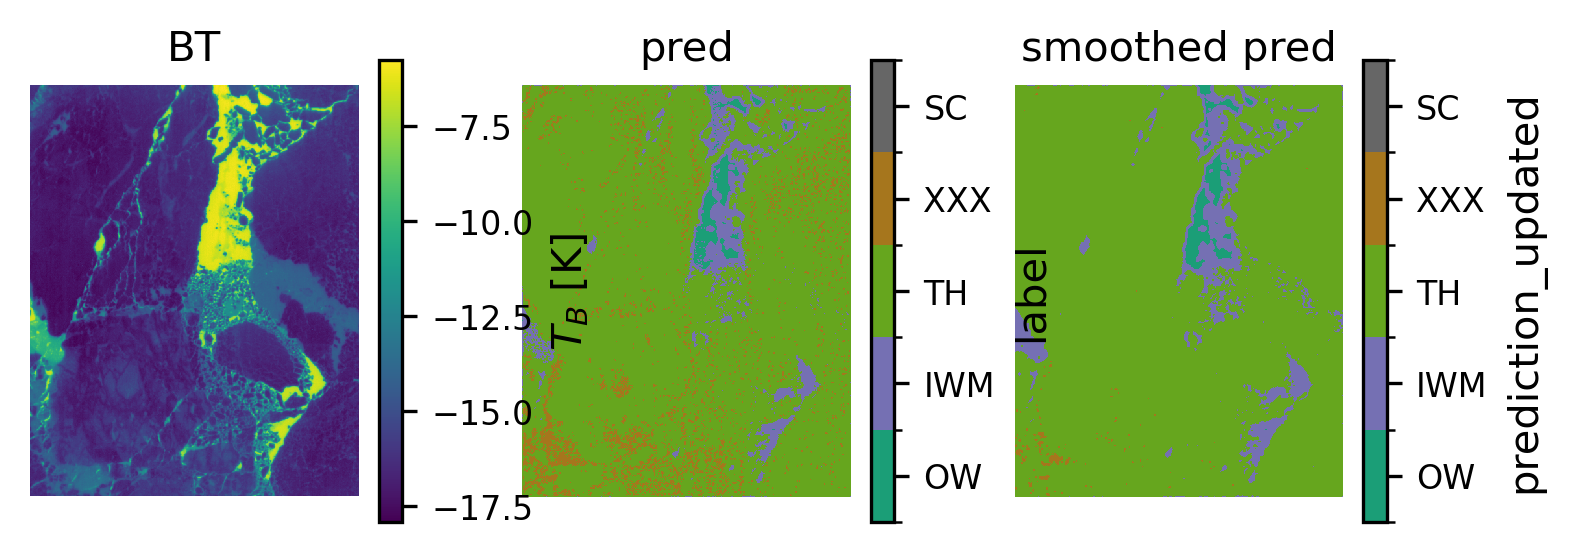

In [104]:
import matplotlib.pyplot as plt
import json
plt.rcParams.update(json.load(open('/projekt_agmwend/home_rad/Joshua/MasterArbeit/plot_settings.json')))

fig, ax = plt.subplot_mosaic(
    """
    ABC
    """,
    figsize=(6, 2)

)

ds_predicted['label'].plot.contourf(levels=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], cmap='Dark2', ax=ax['B'])
cbar = ax['B'].collections[0].colorbar
cbar.set_ticks([1, 2, 3, 4, 5])
cbar.set_ticklabels(['OW', 'IWM', 'TH', 'XXX', 'SC'])
test_slice.BT_2D.isel(band=0).plot.imshow(ax=ax['A'], cmap='viridis', cbar_kwargs={'label': r'$T_B$ [K]'})

### smoothen the predictions 
ds_predicted['prediction_updated'].plot.contourf(levels=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], cmap='Dark2', ax=ax['C'])
cbar = ax['C'].collections[0].colorbar
cbar.set_ticks([1, 2, 3, 4, 5])
cbar.set_ticklabels(['OW', 'IWM', 'TH', 'XXX', 'SC'])

ax['A'].set_title('BT')
ax['B'].set_title('pred')
ax['C'].set_title('smoothed pred')

for a in ax.values():
    a.set_aspect('equal')
    a.axis('off')
    a.grid(False)